# Recommendations with IBM ðŸ˜º
> Udacity project with IBM Watson Studio platform data

- toc: true 
- badges: true
- comments: true
- author: Jaekang Lee
- categories: [python, collaborative recommendation, EDA, IBM, SVM, Matrix Factorization, Udacity]

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

article_id                                              title  \
0      1430.0  using pixiedust for fast, flexible, and easier...   
1      1314.0       healthcare python streaming application demo   
2      1429.0         use deep learning for image classification   
3      1338.0          ml optimization using cognitive assistant   
4      1276.0          deploy your python model as a restful api   

                                      email  
0  ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7  
1  083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b  
2  b96a4f2e92d8572034b1e9b28f9ac673765cd074  
3  06485706b34a5c9bf2a0ecdac41daf7e7654ceb7  
4  f01220c46fc92c6e6b161b1849de11faacd7ccb2

In [266]:
# Show df_content to get an idea of the data
df_content.head()

doc_body  \
0  Skip navigation Sign in SearchLoading...\r\n\r...   
1  No Free Hunch Navigation * kaggle.com\r\n\r\n ...   
2  â˜° * Login\r\n * Sign Up\r\n\r\n * Learning Pat...   
3  DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...   
4  Skip navigation Sign in SearchLoading...\r\n\r...   

                                     doc_description  \
0  Detect bad readings in real time using Python ...   
1  See the forest, see the trees. Here lies the c...   
2  Hereâ€™s this weekâ€™s news in Data Science and Bi...   
3  Learn how distributed DBs solve the problem of...   
4  This video demonstrates the power of IBM DataS...   

                                       doc_full_name doc_status  article_id  
0  Detect Malfunctioning IoT Sensors with Streami...       Live           0  
1  Communicating data science: A guide to present...       Live           1  
2         This Week in Data Science (April 18, 2017)       Live           2  
3  DataLayer Conference: Boost the performance of...       Live           3  
4      Analyze NY Restaurant data using Spark in DSX       Live           4

### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

In [267]:
df['email'].value_counts().median()

3.0

In [268]:
df['email'].value_counts().max()

364

count                                        45976
unique                                        5148
top       2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq                                           364
Name: email, dtype: object


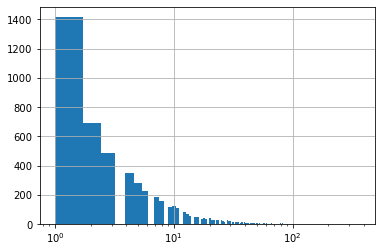

In [269]:
# Visualization and Descriptive Stats
print(df['email'].describe())
df['email'].value_counts().hist(bins=500)
plt.xscale('log')
plt.show()

Explore and remove duplicate articles from the **df_content** dataframe.  

In [271]:
# Find and explore duplicate articles
df_content[df_content.duplicated(subset=['article_id'])]

doc_body  \
365  Follow Sign in / Sign up Home About Insight Da...   
692  Homepage Follow Sign in / Sign up Homepage * H...   
761  Homepage Follow Sign in Get started Homepage *...   
970  This video shows you how to construct queries ...   
971  Homepage Follow Sign in Get started * Home\r\n...   

                                       doc_description  \
365  During the seven-week Insight Data Engineering...   
692  One of the earliest documented catalogs was co...   
761  Todayâ€™s world of data science leverages data f...   
970  This video shows you how to construct queries ...   
971  If you are like most data scientists, you are ...   

                                         doc_full_name doc_status  article_id  
365                       Graph-based machine learning       Live          50  
692  How smart catalogs can turn the big data flood...       Live         221  
761  Using Apache Spark as a parallel processing fr...       Live         398  
970                              Use the Primary Index       Live         577  
971  Self-service data preparation with IBM Data Re...       Live         232

In [272]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset=['article_id'])

In [273]:
len(df_content[df_content.duplicated(subset=['article_id'])]) # check

0

In [274]:
print(len(df['article_id'].unique()))
print(len(df_content['article_id'].unique()))
print(len(df['email'].unique()))
len(df)

714
1051
5149


45993

find the most viewed **article_id**, as well as how often it was viewed.  

In [276]:
df['article_id'].value_counts().head()

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [278]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

article_id                                              title  user_id
0      1430.0  using pixiedust for fast, flexible, and easier...        1
1      1314.0       healthcare python streaming application demo        2
2      1429.0         use deep learning for image classification        3
3      1338.0          ml optimization using cognitive assistant        4
4      1276.0          deploy your python model as a restful api        5

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

return the **n** top articles ordered with most interactions as the top. 

In [280]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    result = []
    top_articles_idx = df['article_id'].value_counts().index[:n]
    for id in top_articles_idx:
        result.append(list(df[df['article_id']==id]['title'].drop_duplicates())[0])
    
    return result # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    return list(df['article_id'].value_counts().index[:n]) # Return the top article ids

In [281]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [283]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    #user_item = pd.pivot_table(df, index=['user_id'], columns=['article_id'], values=['title'],aggfunc=[np.sum], fill_value=0)
    user_item = df.groupby(['user_id', 
                            'article_id'])['title'].count().unstack().notnull().astype(int).fillna(0)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

In [285]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    # sort by similarity
    similarities = user_item.dot(user_item.iloc[user_id-1]).sort_values(ascending=False)
    # create list of just the ids
    ids = similarities.index
    # remove the own user's id
    most_similar_users = ids
    return list(most_similar_users.drop(user_id)) # return a list of the users in order from most to least similar
        

return the articles you would recommend to each user. 

In [287]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    for i in article_ids:
        article_names += list(df[df['article_id'].astype(str) == i]['title'].unique())
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    article_ids = user_item.iloc[user_id-1]
    article_ids = [i for i in article_ids[article_ids == 1].index.astype(str)]
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = set()
    i = 0
    user_articles, _ = get_user_articles(user_id)
    while len(recs) < m:
        similar_user_ids = find_similar_users(user_id)
        similar_user_articles, _ = get_user_articles(similar_user_ids[i])
        recs.update(list(set(similar_user_articles)-set(user_articles)))
        i += 1
    
    return list(recs)[:m] # return your recommendations for this user_id    

In [288]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['502    forgetting the past to learn the future: long ...\nName: title, dtype: object',
 'discover hidden facebook usage insights',
 'aspiring data scientists! start to learn statistics with these 6 books!',
 'using bigdl in dsx for deep learning on spark',
 'using machine learning to predict parking difficulty',
 'data science platforms are on the rise and ibm is leading the way',
 'a dynamic duo â€“ inside machine learning â€“ medium',
 'this week in data science (february 14, 2017)',
 'what is smote in an imbalanced class setting (e.g. fraud detection)?',
 'shaping data with ibm data refinery']

improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [400]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # Your code here
    similar_user = pd.DataFrame(find_similar_users(user_id))
    num_interactions = df['user_id'].value_counts()
    similarities = user_item.dot(user_item.iloc[user_id-1]).sort_values(ascending=False)
    neighbors_df = num_interactions.to_frame(name='num_interactions').merge(pd.DataFrame(similarities).drop(user_id).reset_index(), right_on="user_id", left_index=True)
    neighbors_df = neighbors_df.sort_values(by=[0, 'num_interactions'], ascending=False)
    neighbors_df = neighbors_df.rename(columns={0:"similarity","user_id":"neighbor_id"})
    return neighbors_df # Return the dataframe specified in the doc_string


In [401]:
get_top_sorted_users(20)

num_interactions  neighbor_id  similarity
13                 116          170           2
12                 114         3169           2
9                   97          204           2
15                  95         5138           2
0                   78           40           2
...                ...          ...         ...
2110                 1         1039           0
4091                 1         3150           0
2041                 1         1103           0
4947                 1         3182           0
1356                 1         2049           0

[5148 rows x 3 columns]

In [402]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    recs = []
    top_df = get_top_sorted_users(user_id)
    user_article_ids, _ = get_user_articles(user_id)
    i = 0
    while len(recs) < m:
        similar_user_articles, _ = get_user_articles(top_df['neighbor_id'][i])
        possible_recommendations = (list(set([str(j) for j in similar_user_articles])-set(user_article_ids)))
        top_articles = list(df[df['article_id'].isin(possible_recommendations)]['article_id'].value_counts(ascending=False).index.astype(str))
        recs += top_articles
        i += 1
    recs = recs[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [408]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1162.0', '1304.0', '43.0', '1351.0']

The top 10 recommendations for user 20 are the following article names:
['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model', 'deep learning with tensorflow course by big data university', 'model bike sharing data with spss']


In [409]:
### Tests with a dictionary of results

user1_most_sim = (get_top_sorted_users(1)['neighbor_id'][0])# Find the user that is most similar to user 1 
user131_10th_sim = (get_top_sorted_users(131)['neighbor_id'][9])# Find the 10th most similar user to user 131

We can use get_top_article_ids(n) function to recommend the top articles with most interactions. This will work in general cases since we can assume these articles were more interacted because it drew more people's interest. Another better way to make recommendation to new user may be to recommend top articles but in order of newest. The idea is that it is still popular and it reduces risk of recommending articles based on date it is created. (Since the longer it exists, the more chance it has more interactions than newer ones without much special attraction)  

### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.


In [299]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [300]:
# quick look at the matrix
user_item_matrix.head()

article_id  0.0  100.0  1000.0  1004.0  1006.0  1008.0  101.0  1014.0  1015.0  \
user_id                                                                         
1           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
2           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
3           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
4           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   
5           0.0    0.0     0.0     0.0     0.0     0.0    0.0     0.0     0.0   

article_id  1016.0  ...  977.0  98.0  981.0  984.0  985.0  986.0  990.0  \
user_id             ...                                                   
1              0.0  ...    0.0   0.0    1.0    0.0    0.0    0.0    0.0   
2              0.0  ...    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
3              0.0  ...    1.0   0.0    0.0    0.0    0.0    0.0    0.0   
4              0.0  ...    0.0   0.0    0.0    0.0    0.0    0.0    0.0   
5              0.0  ...    0.0   0.0    0.0    0.0    0.0    0.0    0.0   

article_id  993.0  996.0  997.0  
user_id                          
1             0.0    0.0    0.0  
2             0.0    0.0    0.0  
3             0.0    0.0    0.0  
4             0.0    0.0    0.0  
5             0.0    0.0    0.0  

[5 rows x 714 columns]

In [301]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix)# use the built in to get the three matrices

Remember that SVD require there are no NAN values!!

to get an idea of how the accuracy improves as we increase the number of latent features.

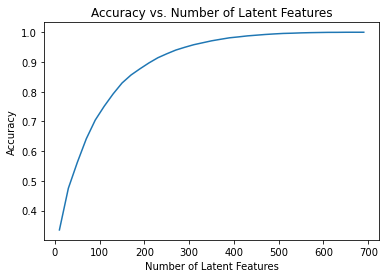

In [302]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

Train test split

In [303]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids as list
    test_arts - all of the test article ids as list
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = list(set(user_item_test.index))
    test_arts = list(set(user_item_test.columns))
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [304]:
print(len(test_idx) - len(user_item_test))
print(len(test_arts))
print(len(user_item_test))
print(len(test_arts) - len(user_item_test.columns))

0
574
682
0


Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

In [306]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
# fit svd similar to above then use the cells below

In [307]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data
# CODE REFERENCE: https://github.com/nicovillena/recommendations-with-ibm/blob/master/Recommendations_with_IBM.ipynb

# train idx and articles
train_idx = np.array(user_item_train.index)
train_arts = np.array(user_item_train.columns)

# intersection between test idx, articles and train idx, articles
#test_idx_int = np.array(set(test_idx).intersection(set(train_idx))).sort()
#test_arts_int = np.array(set(test_arts).intersection(set(train_arts))).sort()
test_idx_int = np.intersect1d(test_idx, train_idx)
test_arts_int = np.intersect1d(test_arts, train_arts)

# user and article positions of test subset in training and vice versa
train_indexes = np.where(np.in1d(train_idx, test_idx_int))[0]
train_articles = np.where(np.in1d(train_arts, test_arts_int))[0]
test_indexes = np.where(np.in1d(test_idx, test_idx_int))[0]
test_articles = np.where(np.in1d(test_arts, test_arts_int))[0]

# subset of user_item matrix containing train and test set
u_item_test = user_item_test.iloc[test_indexes,:]
print(u_item_test.shape)
u_item_train = user_item_train.iloc[train_indexes, train_articles]
print(u_item_train.shape)

(20, 574)
(20, 574)


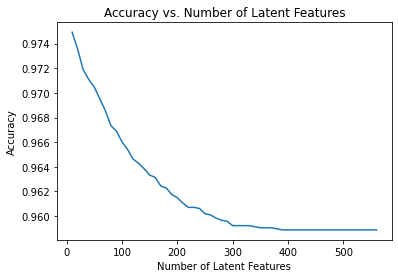

In [308]:
latent_feats = np.arange(10,570,10)
sum_errors = []

# iterate to find best number of latent_feats
for k in latent_feats:
    
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    # restructure test with k latent features
    s_test_new, u_test_new, vt_test_new = s_new, u_new[train_indexes,:], vt_new[:,train_articles]
    
    # take dot product
    u_item_test_set_pred = np.around(np.dot(np.dot(u_test_new, s_test_new), vt_test_new))
    
    # compute error for each prediction to actual value
    error = np.subtract(u_item_test, u_item_test_set_pred)
    
    # total errors and keep track of them
    total_error = np.sum(np.sum(np.abs(error)))
    sum_errors.append(total_error)
    
    
# Plot
dim = u_item_test.shape[0] * u_item_test.shape[1]
plt.plot(latent_feats, 1 - np.array(sum_errors) / dim);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

## Conclusion
We can see that as the number of latent feature increases, the accuracy decreases. Which is a sign of overfitting since this is a plot of the test set. This can be explained by the small number of users who have both testing and training datasets. We conclude that it is robust enough to decide if our model is ready for deployment. 
To fix this problem, we can collect more data or use regularizations. In addition we can perform an online A/B testing to measure whether rank based recommendation system or matrix recommendation performs better.
Note that our accuracy metrics may not be the best measure of our performance since it is so skewed that by just hard coding, we can correctly guess all except 20. Better metric to use may be precision/recall.

Make html notebook

In [407]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0